# M07. Pulls
- This predicts when starting pitchers are removed from a game
- Type: Model
- Run Frequency: Irregular
- Sources:
    - MLB API
    - Steamer
- Dates:
    - Created: 11/1/2023
    - Updated: 4/21/2024

### Imports

In [1]:
%run "U1. Imports.ipynb"
%run "U2. Utilities.ipynb"
%run "U3. Classes.ipynb"
%run "U4. Datasets.ipynb"

In [2]:
# from sklearn.model_selection import train_test_split, GridSearchCV
# from sklearn.metrics import log_loss, classification_report, f1_score, make_scorer
# from sklearn.neural_network import MLPClassifier
# from sklearn.ensemble import RandomForestClassifier, VotingClassifier
# from sklearn.linear_model import LinearRegression, LogisticRegression
# from sklearn.preprocessing import StandardScaler, LabelEncoder
# from sklearn.inspection import permutation_importance
# from sklearn.datasets import make_classification
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.multiclass import OneVsRestClassifier
# from sklearn.cluster import KMeans
# from sklearn.naive_bayes import GaussianNB, MultinomialNB
# from tensorflow import keras
# from sklearn.impute import SimpleImputer

# import joblib
# import matplotlib.pyplot as plt

In [3]:
running_steals = True
run_datasets = False

In [4]:
# %run "A02. MLB API.ipynb"
%run "A03. Steamer.ipynb"

### Dataset

Read in Park x Weather Factors

In [5]:
multiplier_df = pd.read_csv(os.path.join(baseball_path, "Multiplier Dataset.csv"))

Create PA model inputs

In [6]:
# complete_dataset = create_pa_inputs(multiplier_df, 2015, 2024, short=50, long=300, adjust=True)

In [7]:
# complete_dataset.to_csv(os.path.join(baseball_path, "nn_dataset.csv"), index=False)

In [8]:
complete_dataset = pd.read_csv(os.path.join(baseball_path, "nn_dataset.csv"))

### Adjust

In the model, pulls occur before the PA, not after, so innings and outs need to be adjusted

In [9]:
complete_dataset['inning_adj'] = complete_dataset['inning'] + (complete_dataset['outs'] == 3).astype(int)
complete_dataset['outs_adj'] = complete_dataset['outs'] * (complete_dataset['outs'] != 3).astype(int)

To account for the inning shift, inning stat sums should be reset

In [10]:
for variable in events_list + ['faced', 'reached', 'outs_pa']:
    complete_dataset[f'{variable}_inning_adj'] = np.where(complete_dataset['outs'] == 3, 0, complete_dataset[f'{variable}_inning']) 
    complete_dataset[f'{variable}_game_adj'] = complete_dataset[f'{variable}_game'].copy()

To match the model, imputation flags should be determined at the beginning of the game 

In [11]:
complete_dataset['imp_p_adj'] = complete_dataset.groupby(['gamePk', 'pitcher'])['imp_p'].transform('max')

In [12]:
complete_dataset.query('gamePk == 413661')[['date', 'atBatIndex', 'halfInning', 'inning', 'outs', 'inning_adj', 'outs_adj', 'outs_pa', 'outs_pre',
                                            'pitchHand', 'batSide', 'pitcherName', 'batterName', 'eventsModel', 
                                            'faced_inning', 'faced_game', 'faced_inning_adj', 'b1_inning', 'b1_inning_adj', 'imp_p_adj', 'pulled']].head(10)

,date,atBatIndex,halfInning,inning,outs,inning_adj,outs_adj,outs_pa,outs_pre,pitchHand,batSide,pitcherName,batterName,eventsModel,faced_inning,faced_game,faced_inning_adj,b1_inning,b1_inning_adj,imp_p_adj,pulled
0,20150405,0,top,1,1,1,1,1.0,0,L,L,Jon Lester,Matt Carpenter,go,1,1,1,0,0,1,0
1,20150405,1,top,1,1,1,1,0.0,1,L,L,Jon Lester,Jason Heyward,b2,2,2,2,0,0,1,0
2,20150405,2,top,1,1,1,1,0.0,1,L,R,Jon Lester,Matt Holliday,b1,3,3,3,1,1,1,0
3,20150405,3,top,1,2,1,2,1.0,1,L,R,Jon Lester,Jhonny Peralta,so,4,4,4,1,1,1,0
4,20150405,4,top,1,3,2,0,1.0,2,L,L,Jon Lester,Matt Adams,so,5,5,0,1,0,1,0
5,20150405,5,bottom,1,0,1,0,0.0,0,R,L,Adam Wainwright,Dexter Fowler,b2,1,1,1,0,0,1,0
6,20150405,6,bottom,1,1,1,1,1.0,0,R,R,Adam Wainwright,Jorge Soler,go,2,2,2,0,0,1,0
7,20150405,7,bottom,1,2,1,2,1.0,1,R,L,Adam Wainwright,Anthony Rizzo,so,3,3,3,0,0,1,0
8,20150405,8,bottom,1,3,2,0,1.0,2,R,R,Adam Wainwright,Starlin Castro,go,4,4,0,0,0,1,0
9,20150405,9,top,2,1,2,1,1.0,0,L,R,Jon Lester,Yadier Molina,so,1,6,1,0,0,1,0


### Steamer

In [13]:
# Read in Steamer hitters 
steamer_pitchers_df = pd.read_csv(os.path.join(baseball_path, "A03. Steamer", "steamer_pitchers_weekly_log.csv"), encoding='iso-8859-1')
# Clean
steamer_pitchers_df2 = clean_steamer_pitchers(steamer_pitchers_df)
steamer_pitchers_df2.dropna(subset=pitcher_stats_fg2, inplace=True)

### Merge

Format dates

In [14]:
complete_dataset['date_time'] = pd.to_datetime(complete_dataset['date'], format='%Y%m%d')
steamer_pitchers_df2['date_time'] = pd.to_datetime(steamer_pitchers_df2['date'], format='%Y%m%d')

Remove missing pitchers (occurs occassionally in 2014)

In [15]:
steamer_pitchers_df2 = steamer_pitchers_df2[~steamer_pitchers_df2['mlbamid'].isna()]

Set data types

In [16]:
complete_dataset['pitcher'] =complete_dataset['pitcher'].astype(int).astype(str)
steamer_pitchers_df2['pitcher'] = steamer_pitchers_df2['mlbamid'].astype(int).astype(str)

Merge asof most recent date in Steamer

In [90]:
complete_merged_df = pd.merge_asof(
    complete_dataset,
    steamer_pitchers_df2,
    on='date_time',
    by='pitcher', 
    suffixes=('', '_fg'),
    direction='backward'  # Use 'backward', 'forward', or 'nearest' as appropriate
)

### Select Data 

Only keep one observation per at bat

In [92]:
complete_merged_df.drop_duplicates(subset=['date', 'gamePk', 'atBatIndex'], keep='last', inplace=True)

Keep those with reasonable IP/start projections 

In [93]:
complete_merged_df = complete_merged_df.query('IP_start > 3 and IP_start < 8')

Only keep starting pitchers

In [94]:
complete_merged_df = complete_merged_df[complete_merged_df['starter'] == 1]

Drop early observations

In [95]:
complete_merged_df = complete_merged_df[complete_merged_df['game_date'] > '2022-01-01']

Inning dummies

In [96]:
for inning in range(1, 12):
    complete_merged_df[f'inning_{inning}'] = (complete_merged_df['inning_adj'] == inning).astype(int)
complete_merged_df['inning_11'] = (complete_merged_df['inning_adj'] >= 11).astype(int)

In [97]:
inning_dummy_list = [col for col in complete_merged_df.columns if col.startswith("inning_")]
inning_dummy_list.remove('inning_adj')

Out dummies

In [98]:
for out in range(0, 3):
    complete_merged_df[f'outs_{out}'] = (complete_merged_df['outs_adj'] == out).astype(int)

In [99]:
out_dummy_list = ['outs_0', 'outs_1', 'outs_2']

Cumulative variables

In [100]:
cumulative_inning_list = [col for col in complete_merged_df.columns if col.endswith("_inning_adj")]

Exclude outs recorded by the pitcher that inning (redudant with inning dummies for starting pitchers)

In [101]:
cumulative_inning_list.remove('outs_pa_inning_adj')

In [102]:
cumulative_game_list = [col for col in complete_merged_df.columns if col.endswith("_game_adj")]

Game state variables

In [103]:
game_state_list = ['pitcherScore', 'batterScore', 'onFirst', 'onSecond', 'onThird']

Steamer variables

In [104]:
steamer_list = ['IP_start']

Imputation dummy

In [105]:
imp_list = ['imp_p_adj']

In [106]:
pull_inputs = cumulative_inning_list + cumulative_game_list + inning_dummy_list + out_dummy_list + game_state_list + steamer_list + imp_list

# Train Models

### Dataset

Split the data both on "pulled" and "imp_p_adj" to ensure training and test datasets are most similar

In [134]:
def balanced_split(df, stratify_cols, random_state=42):
    """
    Creates a 'split' column ensuring an even, random balance for the given stratification columns.

    Parameters:
        df (pd.DataFrame): The input dataframe.
        stratify_cols (list): List of columns to balance the split on.
        random_state (int): Seed for reproducibility.

    Returns:
        pd.DataFrame: Updated dataframe with a 'split' column (0 for training, 1 for test).
    """
    np.random.seed(random_state)  # Set seed for reproducibility
    df = df.sample(frac=1).reset_index(drop=True)  # Shuffle before splitting

    split_values = []
    
    for _, group in df.groupby(stratify_cols):
        n = len(group)
        half_n = n // 2  # Ensure a 50-50 split

        split_vals = np.array([0] * half_n + [1] * (n - half_n))  # Split evenly
        np.random.shuffle(split_vals)  # Randomize within the group

        split_values.extend(split_vals)

    df['split'] = split_values
    return df

In [ ]:
complete_merged_df = balanced_split(complete_merged_df, stratify_cols=['pulled', 'imp_p_adj'], random_state=100)

In [135]:
training_dataset = complete_merged_df[complete_merged_df['split'] == 0].drop('split', axis=1)
testing_dataset = complete_merged_df[complete_merged_df['split'] == 1].drop('split', axis=1)

In [136]:
testing_dataset.reset_index(inplace=True, drop=True)

48

### Pulls

In [179]:
%%time
pulls_filename = f"predict_pulls_{todaysdate}.sav"
print(pulls_filename)

random_state = 900
layers = (49,49,49,49,49)
# layers = (100)

# Define the individual models in the ensemble
models = [
    MLPClassifier(hidden_layer_sizes=layers, activation='relu', random_state=random_state+1, early_stopping=True, max_iter=100),  
    MLPClassifier(hidden_layer_sizes=layers, activation='relu', random_state=random_state+2, early_stopping=True, max_iter=100),  
    MLPClassifier(hidden_layer_sizes=layers, activation='relu', random_state=random_state+3, early_stopping=True, max_iter=100),  
    ]

# Create the ensemble classifier using VotingClassifier
model_pulls = VotingClassifier(estimators=[('model'+str(i+1), model) for i, model in enumerate(models)], voting='soft', n_jobs=-2).fit(training_dataset[pull_inputs], training_dataset[['pulled']].values.ravel())

# Save model
pickle.dump(model_pulls, open(os.path.join(model_path, "M07. Pulls", pulls_filename), 'wb'))

predict_pulls_20250128.sav
CPU times: total: 156 ms
Wall time: 30.2 s


In [180]:
# Make predictions
proba = model_pulls.predict_proba(testing_dataset[pull_inputs])
testing_dataset['is_kept_pred'] = proba[:, 0]  # Assign the first column of probabilities
testing_dataset['is_pulled_pred'] = proba[:, 1]  # Assign the second column of probabilities

# Graph

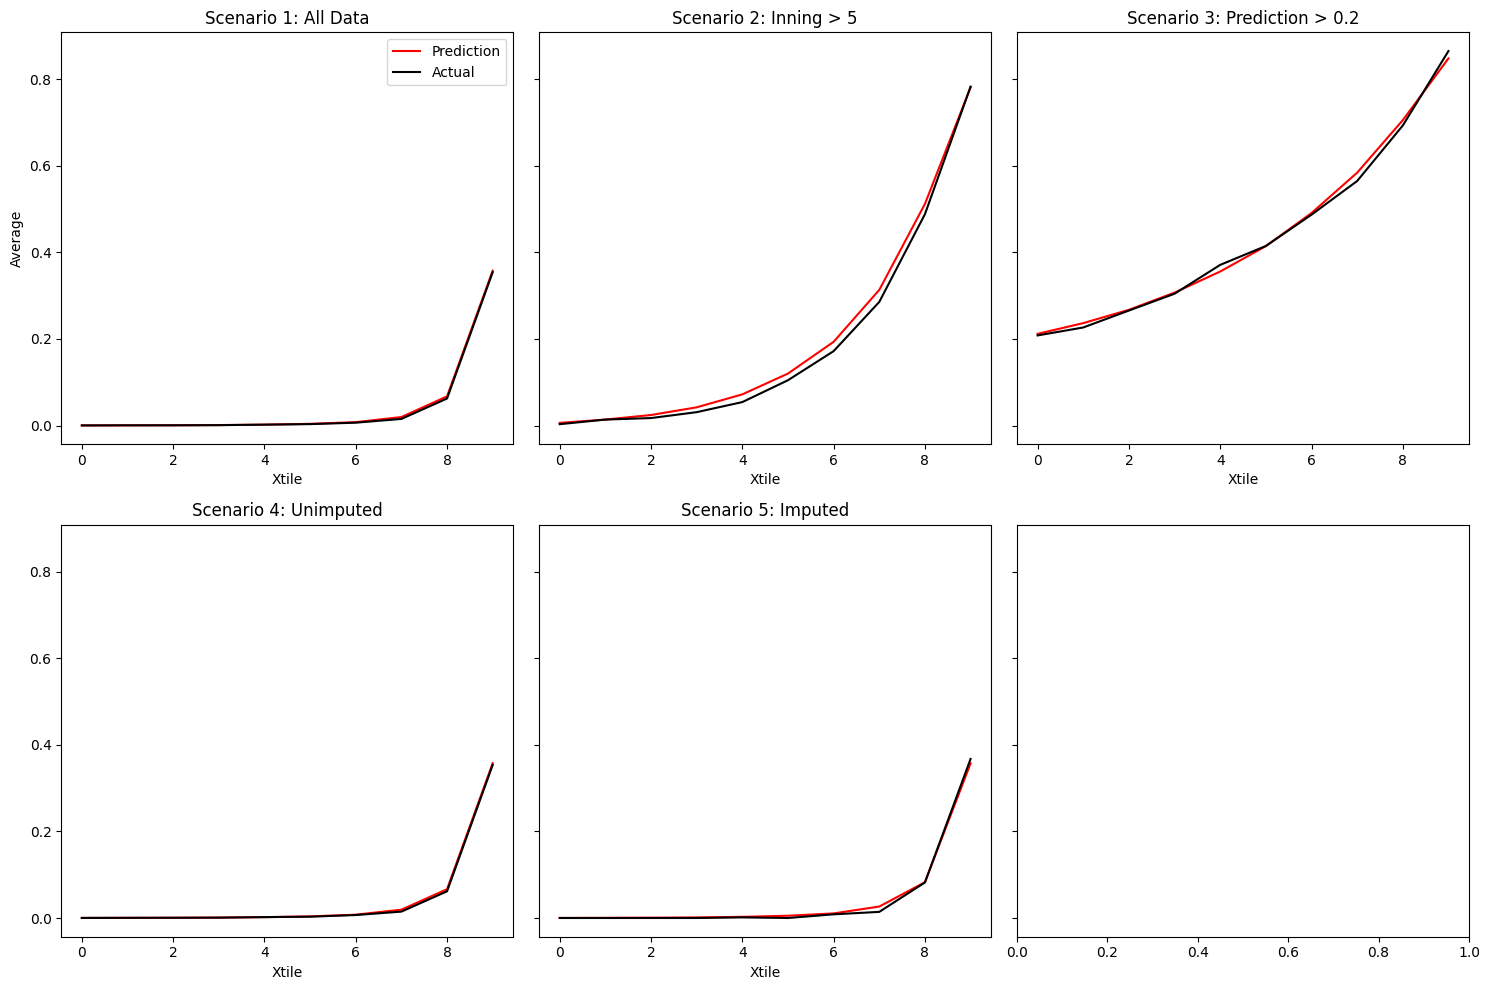

In [181]:
xtiles = 10

# First Scenario
testing_dataset['xtile1'] = pd.qcut(testing_dataset['is_pulled_pred'], xtiles, labels=False)
is_pulled_df1 = testing_dataset.groupby('xtile1')[['pulled', 'is_pulled_pred']].mean().reset_index()

# Second Scenario
testing_dataset['xtile2'] = pd.qcut(testing_dataset.query('inning > 5')['is_pulled_pred'], xtiles, labels=False)
is_pulled_df2 = testing_dataset.query('inning > 5').groupby('xtile2')[['pulled', 'is_pulled_pred']].mean().reset_index()

# Third Scenario
testing_dataset['xtile3'] = pd.qcut(testing_dataset.query('is_pulled_pred > 0.2')['is_pulled_pred'], xtiles, labels=False)
is_pulled_df3 = testing_dataset.query('is_pulled_pred > 0.2').groupby('xtile3')[['pulled', 'is_pulled_pred']].mean().reset_index()

# Unimputed
testing_dataset['xtile4'] = pd.qcut(testing_dataset.query('imp_p_adj == 0')['is_pulled_pred'], xtiles, labels=False)
is_pulled_df4 = testing_dataset.query('imp_p_adj == 0').groupby('xtile4')[['pulled', 'is_pulled_pred']].mean().reset_index()

# Imputed
testing_dataset['xtile5'] = pd.qcut(testing_dataset.query('imp_p_adj == 1')['is_pulled_pred'], xtiles, labels=False)
is_pulled_df5 = testing_dataset.query('imp_p_adj == 1').groupby('xtile5')[['pulled', 'is_pulled_pred']].mean().reset_index()

# Create a figure with 2x3 layout
fig, axes = plt.subplots(2, 3, figsize=(15, 10), sharey=True)



# Plot each graph
axes[0,0].plot(is_pulled_df1['xtile1'], is_pulled_df1['is_pulled_pred'], color='red', label='Prediction')
axes[0,0].plot(is_pulled_df1['xtile1'], is_pulled_df1['pulled'], color='black', label='Actual')
axes[0,0].set_title('Scenario 1: All Data')
axes[0,0].set_xlabel('Xtile')
axes[0,0].set_ylabel('Average')

axes[0,1].plot(is_pulled_df2['xtile2'], is_pulled_df2['is_pulled_pred'], color='red', label='Prediction')
axes[0,1].plot(is_pulled_df2['xtile2'], is_pulled_df2['pulled'], color='black', label='Actual')
axes[0,1].set_title('Scenario 2: Inning > 5')
axes[0,1].set_xlabel('Xtile')

axes[0,2].plot(is_pulled_df3['xtile3'], is_pulled_df3['is_pulled_pred'], color='red', label='Prediction')
axes[0,2].plot(is_pulled_df3['xtile3'], is_pulled_df3['pulled'], color='black', label='Actual')
axes[0,2].set_title('Scenario 3: Prediction > 0.2')
axes[0,2].set_xlabel('Xtile')

axes[1,0].plot(is_pulled_df4['xtile4'], is_pulled_df4['is_pulled_pred'], color='red', label='Prediction')
axes[1,0].plot(is_pulled_df4['xtile4'], is_pulled_df4['pulled'], color='black', label='Actual')
axes[1,0].set_title('Scenario 4: Unimputed')
axes[1,0].set_xlabel('Xtile')

axes[1,1].plot(is_pulled_df5['xtile5'], is_pulled_df5['is_pulled_pred'], color='red', label='Prediction')
axes[1,1].plot(is_pulled_df5['xtile5'], is_pulled_df5['pulled'], color='black', label='Actual')
axes[1,1].set_title('Scenario 5: Imputed')
axes[1,1].set_xlabel('Xtile')

# Add a legend to the first plot
axes[0,0].legend()

# Adjust layout for clarity
plt.tight_layout()
plt.show()


In [182]:
testing_dataset.query('inning > 5').groupby('imp_p_adj')[['pulled', 'is_pulled_pred']].mean()

,pulled,is_pulled_pred
imp_p_adj,,
0,0.193799,0.206776
1,0.243191,0.241414


In [184]:
testing_dataset.query('year >= 2022').query('inning > 0').groupby('imp_p_adj')[['pulled', 'is_pulled_pred']].mean()

,pulled,is_pulled_pred
imp_p_adj,,
0,0.044359,0.045855
1,0.047370,0.048751
